# Transport Mode Inference (Expanded Features Only)

This notebook keeps only the expanded-features pipeline: load data, engineer speed, build an expanded numeric feature set with optional transforms, select k via silhouette, cluster with KMeans, label modes, visualize, and export results.


In [3]:
# Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
print(os.getcwd())

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

DATA_PATH = 'dynamic_supply_chain_logistics_dataset.csv'
assert os.path.exists(DATA_PATH), f"CSV not found at {DATA_PATH}"

na_tokens = ['', ' ', 'na', 'n/a', 'NA', 'N/A', 'null', 'NULL', 'none', 'None', 'nan', 'NaN', 'NAN', '-', '--']

df = pd.read_csv(DATA_PATH, na_values=na_tokens, keep_default_na=True, low_memory=False)
print('Rows, Cols:', df.shape)
df.head(3)


d:\Projects\sudata_datathon\notebooks\jupyter
Rows, Cols: (32065, 26)


,timestamp,vehicle_gps_latitude,vehicle_gps_longitude,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,weather_condition_severity,port_congestion_level,shipping_costs,supplier_reliability_score,lead_time_days,historical_demand,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation
0,2021-01-01 00:00:00,40.375568,-77.014318,5.136512,4.998009,5.927586,985.716862,4.951392,0.481294,0.761166,0.359066,4.289160,456.503853,0.986064,2.128009,100.772854,0.574400,0.777263,1.182116,0.502006,0.033843,0.978599,0.506152,0.885291,Moderate Risk,9.110682
1,2021-01-01 01:00:00,33.507818,-117.036902,5.101512,0.984929,1.591992,396.700206,1.030379,0.620780,0.196594,0.230660,7.018373,640.408205,0.463233,12.608166,5313.738114,-9.753493,0.091839,9.611988,0.966774,0.201725,0.918586,0.980784,0.544178,High Risk,8.175281
2,2021-01-01 02:00:00,30.020640,-75.269224,5.090803,4.972665,8.787765,832.408935,4.220229,0.810933,0.152742,0.027210,9.605064,155.749314,0.598561,14.124452,1595.049146,-6.491034,0.253529,6.570431,0.945627,0.264045,0.394215,0.998633,0.803322,High Risk,1.283594


In [4]:
# Missing stats (reference only)
na_counts = df.isna().sum()
na_pct = (na_counts / len(df) * 100).round(3)
missing_summary = (
    pd.DataFrame({'dtype': df.dtypes.astype(str), 'missing_count': na_counts, 'missing_pct': na_pct})
    .sort_values('missing_pct', ascending=False)
)
missing_summary.head(10)


,dtype,missing_count,missing_pct
timestamp,object,0,0.0
vehicle_gps_latitude,float64,0,0.0
risk_classification,object,0,0.0
delay_probability,float64,0,0.0
disruption_likelihood_score,float64,0,0.0
fatigue_monitoring_score,float64,0,0.0
driver_behavior_score,float64,0,0.0
customs_clearance_time,float64,0,0.0
route_risk_level,float64,0,0.0
cargo_condition_status,float64,0,0.0


In [5]:
# Engineer speed (km/h) from GPS and timestamp
_df = df.copy()
_df['timestamp'] = pd.to_datetime(_df['timestamp'], errors='coerce')
_df = _df.sort_values('timestamp')

R = 6371.0
lat = np.deg2rad(_df['vehicle_gps_latitude'].astype(float))
lon = np.deg2rad(_df['vehicle_gps_longitude'].astype(float))

dlat = lat.diff()
dlon = lon.diff()
a = np.sin(dlat/2)**2 + np.cos(lat.shift()) * np.cos(lat) * np.sin(dlon/2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
dist_km = R * c

_dt = _df['timestamp'].diff().dt.total_seconds() / 3600.0
speed_kmh = (dist_km / _dt).replace([np.inf, -np.inf], np.nan)
_df['speed_kmh'] = speed_kmh


In [6]:
# Expanded features build
USE_ALL_NUMERIC = True
APPLY_LOG_TRANSFORMS = True
CORR_PRUNE = True
CORR_THRESHOLD = 0.95
APPLY_PCA = False
PCA_COMPONENTS = 10

EXCLUDE_COLS = set(['timestamp', 'risk_classification'])

num_cols_all = _df.select_dtypes(include=[np.number]).columns.tolist()
num_cols_all = [c for c in num_cols_all if c not in EXCLUDE_COLS]

selected_cols = num_cols_all
X_full = _df[selected_cols].copy()

if APPLY_LOG_TRANSFORMS:
    log_candidates = []
    for col in selected_cols:
        s = X_full[col]
        if s.min(skipna=True) >= 0 and s.skew(skipna=True) > 1.0:
            log_candidates.append(col)
    for col in log_candidates:
        X_full[col] = np.log1p(X_full[col])
    print('Applied log1p to:', log_candidates)

X_full = X_full.interpolate(limit_direction='both').ffill().bfill()

if CORR_PRUNE and len(selected_cols) > 1:
    corr = X_full.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > CORR_THRESHOLD)]
    kept_cols = [c for c in X_full.columns if c not in to_drop]
    if len(kept_cols) >= max(3, PCA_COMPONENTS):
        X_full = X_full[kept_cols]
        print('Correlation pruning removed:', to_drop)
    else:
        print('Correlation pruning skipped (would remove too many cols).')

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)
feature_cols = list(X_full.columns)

if APPLY_PCA:
    from sklearn.decomposition import PCA
    pca = PCA(n_components=min(PCA_COMPONENTS, X_scaled.shape[1]))
    X_scaled = pca.fit_transform(X_scaled)
    print('PCA components:', X_scaled.shape[1])

print('Expanded feature count:', len(feature_cols))
print('NA remaining in features:', int(pd.DataFrame(X_scaled).isna().sum().sum()))


Applied log1p to: ['fuel_consumption_rate']
Correlation pruning removed: []
Expanded feature count: 25
NA remaining in features: 0


In [7]:
# Silhouette-based K selection and final KMeans
k_range = range(2, 13)
scores = {}
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores[k] = score

best_k = max(scores, key=scores.get)
print('Silhouette by k:', scores)
print('Selected best_k =', best_k)

km = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
cluster_labels = km.fit_predict(X_scaled)
_df['cluster_id'] = cluster_labels


Silhouette by k: {2: 0.0310747299061275, 3: 0.031750041874728005, 4: 0.031529688985988555, 5: 0.03296701500941294, 6: 0.0304213968857043, 7: 0.02675121846530584, 8: 0.02218536624546085, 9: 0.018841303397334128, 10: 0.017918704739864278, 11: 0.018446596710622196, 12: 0.019922036847308033}
Selected best_k = 5


In [8]:
# Heuristic mode labeling based on cluster profiles
cluster_profile = _df.groupby('cluster_id')[feature_cols].median()
cluster_profile_ranked = cluster_profile.rank(pct=True)

labels = {}
for cid, row in cluster_profile_ranked.iterrows():
    # Air: high speed and high cost
    if ('speed_kmh' in row and 'shipping_costs' in row and
        row['speed_kmh'] > 0.9 and row['shipping_costs'] > 0.7):
        labels[cid] = 'Air'
    # Sea: very low speed, high port congestion, long lead time
    elif ('speed_kmh' in row and 'port_congestion_level' in row and 'lead_time_days' in row and
          row['speed_kmh'] < 0.2 and row['port_congestion_level'] > 0.7 and row['lead_time_days'] > 0.7):
        labels[cid] = 'Sea'
    # Road: higher traffic congestion and low customs time
    elif 'traffic_congestion_level' in row and 'customs_clearance_time' in row and \
         row['traffic_congestion_level'] > 0.6 and row['customs_clearance_time'] < 0.5:
        labels[cid] = 'Road'
    else:
        labels[cid] = 'Rail'

_df['inferred_mode'] = _df['cluster_id'].map(labels)

print('Cluster counts:')
print(_df['cluster_id'].value_counts().sort_index())
print('\nMode counts:')
print(_df['inferred_mode'].value_counts())


Cluster counts:
cluster_id
0    9687
1    4751
2    6151
3    4842
4    6634
Name: count, dtype: int64

Mode counts:
inferred_mode
Rail    20589
Air      6634
Road     4842
Name: count, dtype: int64


Saved: dynamic_supply_chain_with_modes_expanded.csv


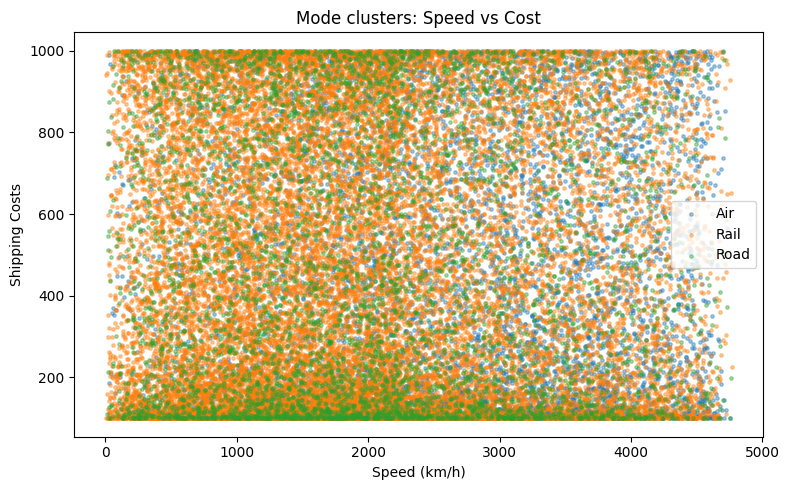

In [9]:
# Export results and quick visualization
OUTPUT_PATH = 'dynamic_supply_chain_with_modes_expanded.csv'
export_cols = ['timestamp', 'vehicle_gps_latitude', 'vehicle_gps_longitude'] + list(feature_cols) + ['cluster_id', 'inferred_mode']

out_df = _df.copy()
out_df[export_cols].to_csv(OUTPUT_PATH, index=False)
print('Saved:', OUTPUT_PATH)

# Quick scatter: speed vs cost by mode
if 'speed_kmh' in out_df.columns and 'shipping_costs' in out_df.columns:
    plt.figure(figsize=(8,5))
    for mode, g in out_df.groupby('inferred_mode'):
        plt.scatter(g['speed_kmh'], g['shipping_costs'], s=6, label=mode, alpha=0.4)
    plt.xlabel('Speed (km/h)')
    plt.ylabel('Shipping Costs')
    plt.title('Mode clusters: Speed vs Cost')
    plt.legend()
    plt.tight_layout()
    plt.show()
